<a href="https://colab.research.google.com/github/OmdenaAI/milan-chapter-agrifoods/blob/main/Yield_Estimation_Omdena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/OmdenaAI/milan-chapter-agrifoods.git

Cloning into 'milan-chapter-agrifoods'...
remote: Enumerating objects: 3951, done.
remote: Counting objects: 100% (570/570), done.
remote: Compressing objects: 100% (345/345), done.
remote: Total 3951 (delta 228), reused 516 (delta 199), pack-reused 3381
Receiving objects: 100% (3951/3951), 572.25 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (998/998), done.
Checking out files: 100% (102/102), done.


In [ ]:
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 43 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


## Check Data

The following datasets are useful for yield prediction


1.   DCSP_COLTIVAZIONI - Crops - full dataset.csv
2.   FAOSTAT_Crop_pro_IT.csv
3.   FAOSTAT_FS_Ind_IT.csv
4.   italy_fertilizers.csv


However, some issues are there


*   I am unable to read 1. due to some error in the data. After inspecting the raw data I have concluded that it can be used in a time-series forecasting model
*   FAOSTAT_Crop_pro_IT.csv contains yield but no data on features
*   However, FAOSTAT_FS_Ind_IT can be used for features instead
*   italy_fertilizers.csv contains data regarding fertilizer quantity which can be used as a feature


In [ ]:
data_dir = Path('/content/milan-chapter-agrifoods/src/data')

In [ ]:
# crops_ds = pd.read_csv(str(data_dir / 'DCSP_COLTIVAZIONI - Crops - full dataset.csv'))
crop_pro_it = pd.read_csv(data_dir / 'FAOSTAT_Crop_pro_IT.csv')
fs_ind_it = pd.read_csv(data_dir / 'FAOSTAT_FS_Ind_IT.csv')
italy_fertilizers = pd.read_csv(data_dir / 'italy_fertilizers.csv')

In [ ]:
crop_pro_it.head()

In [ ]:
crop_pro_it = crop_pro_it.dropna(axis=0, subset=['Value'])

In [ ]:
crop_pro_it.head()

In [ ]:
fs_ind_it.head()

In [ ]:
fs_ind_it['Item'].unique()

In [ ]:
italy_fertilizers.head()

## Crop Yield Monitoring

In [ ]:
data_zip = '/content/milan-chapter-agrifoods/src/tasks/task_4 Modeling/crops_climate_fertilizers.zip'
!unzip "$data_zip"

Archive:  /content/milan-chapter-agrifoods/src/tasks/task_4 Modeling/crops_climate_fertilizers.zip
   creating: crops_climate_fertilizers/
  inflating: crops_climate_fertilizers/fertilizer2006-2021.csv  
  inflating: crops_climate_fertilizers/industrial_crop_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/cereal_crop_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/fruit_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/fresh-veg_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/grapes-olives_climate2006-2021.csv  


### Read Data

In [ ]:
data_dir = Path("/content/crops_climate_fertilizers")
cereal = pd.read_csv(data_dir / 'cereal_crop_climate2006-2021.csv')
print("=== cereal === ")
print(cereal.columns)
fertilizer = pd.read_csv(data_dir / 'fertilizer2006-2021.csv')
print("=== fertilizer === ")
print(fertilizer.columns)
fresh_veg = pd.read_csv(data_dir / 'fresh-veg_climate2006-2021.csv')
print("=== fresh_veg === ")
print(fresh_veg.columns)
fruit = pd.read_csv(data_dir / 'fruit_climate2006-2021.csv')
print("=== fruit === ")
print(fruit.columns)
grapes_olives = pd.read_csv(data_dir / 'grapes-olives_climate2006-2021.csv')
print("=== grapes_olives === ")
print(grapes_olives.columns)
industrial = pd.read_csv(data_dir / 'industrial_crop_climate2006-2021.csv')
print("=== industrial === ")
print(industrial.columns)

=== cereal === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== fertilizer === 
Index(['City', 'Type_fertilizer', 'Year', 'Fertilizers_tonnes'], dtype='object')
=== fresh_veg === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== fruit === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== grapes_olives === 
Index(['City'

In [ ]:
cereal.head()

,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,122.7,42.1833,14.5333
1,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,1124.5,42.1833,14.5333
2,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,16166.9,42.1833,14.5333
3,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,13448.7,42.1833,14.5333
4,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,934.7,42.1833,14.5333


In [ ]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4


In [ ]:
for col in fertilizer:
    print(col)
    print(fertilizer[col].unique())
    print("======================")

City
['Torino' 'Vercelli' 'Biella' 'Verbano-Cusio-Ossola' 'Novara' 'Cuneo'
 'Asti' 'Alessandria' "Valle d'Aosta / Vallée d'Aoste" 'Imperia' 'Savona'
 'Genova' 'La Spezia' 'Varese' 'Como' 'Lecco' 'Sondrio' 'Milano' 'Bergamo'
 'Brescia' 'Pavia' 'Lodi' 'Cremona' 'Mantova'
 'Trentino Alto Adige / Südtirol' 'Provincia Autonoma Bolzano / Bozen'
 'Provincia Autonoma Trento' 'Verona' 'Vicenza' 'Belluno' 'Treviso'
 'Venezia' 'Padova' 'Rovigo' 'Pordenone' 'Udine' 'Gorizia' 'Trieste'
 'Piacenza' 'Parma' "Reggio nell'Emilia" 'Modena' 'Bologna' 'Ferrara'
 'Ravenna' 'Forlì-Cesena' 'Rimini' 'Massa-Carrara' 'Lucca' 'Pistoia'
 'Firenze' 'Prato' 'Livorno' 'Pisa' 'Arezzo' 'Siena' 'Grosseto' 'Perugia'
 'Terni' 'Pesaro e Urbino' 'Ancona' 'Macerata' 'Ascoli Piceno' 'Viterbo'
 'Rieti' 'Roma' 'Latina' 'Frosinone' "L'Aquila" 'Teramo' 'Pescara'
 'Chieti' 'Isernia' 'Campobasso' 'Caserta' 'Messina' 'Oristano'
 'Carbonia-Iglesias' 'Reggio di Calabria' 'Caltanissetta'
 'Barletta-Andria-Trani' 'Benevento' 'Sassari' 

In [ ]:
print(fresh_veg.shape)
fresh_veg.head()

(526897, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,285.9,44.3833,7.55
1,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,934.6,44.3833,7.55
2,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,12478.1,44.3833,7.55
3,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,6268.9,44.3833,7.55
4,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,1740.4,44.3833,7.55


In [ ]:
print(fruit.shape)
fruit.head()

(203150, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,74.4,43.1121,12.3888
1,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,1988.3,43.1121,12.3888
2,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,21619.3,43.1121,12.3888
3,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,17588.4,43.1121,12.3888
4,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,816.6,43.1121,12.3888


In [ ]:
print(grapes_olives.shape)
grapes_olives.head()

(52024, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,83.1,43.85,10.5167
1,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,117.3,43.85,10.5167
2,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,2414.6,43.85,10.5167
3,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,682.2,43.85,10.5167
4,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,92.7,43.85,10.5167


In [ ]:
print(industrial.shape)
industrial.head()

(65820, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,285.9,44.3833,7.55
1,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,934.6,44.3833,7.55
2,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,12478.1,44.3833,7.55
3,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,6268.9,44.3833,7.55
4,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,1740.4,44.3833,7.55


### Modeling

In [ ]:
data = [cereal, fresh_veg, fruit, grapes_olives, industrial]

#### Model for Cereal

In [ ]:
yield_df = data[0]
yield_df.head()

,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,122.7,42.1833,14.5333
1,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,1124.5,42.1833,14.5333
2,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,16166.9,42.1833,14.5333
3,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,13448.7,42.1833,14.5333
4,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,934.7,42.1833,14.5333


In [ ]:
yield_df.describe()

,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
count,208499.000000,2.084990e+05,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000,208499.000000
mean,2013.942825,1.850941e+04,93.464902,13.887966,7.531092,69.543670,2.097073,0.608473,23.989528,4.904121,0.601770,0.609935,49.810228,19.085296,2.079568,1865.022222,42.287983,12.037918
std,4.681311,6.404766e+04,20.405278,4.207869,1.848081,15.281231,0.930072,0.154884,5.709026,3.836303,0.148727,0.149970,12.634100,5.283357,0.777054,4487.867270,5.519015,2.923681
min,2006.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,1.030000e+02,95.800000,12.540000,7.180000,70.560000,1.490000,0.570000,23.480000,2.560000,0.570000,0.580000,46.410000,17.640000,1.640000,34.900000,40.915300,10.033300
50%,2014.000000,8.880000e+02,98.520000,14.630000,7.750000,72.540000,2.000000,0.630000,25.330000,4.490000,0.620000,0.630000,52.110000,20.680000,2.090000,289.700000,43.463100,12.199400
75%,2018.000000,7.400000e+03,99.580000,16.630000,8.430000,74.600000,2.630000,0.700000,26.660000,7.470000,0.680000,0.690000,56.790000,22.290000,2.490000,1452.900000,45.133300,14.167400
max,2022.000000,1.016400e+06,101.700000,20.320000,10.600000,84.970000,4.700000,0.890000,30.900000,14.270000,0.850000,0.840000,74.910000,28.000000,4.990000,98671.600000,46.500000,18.169100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


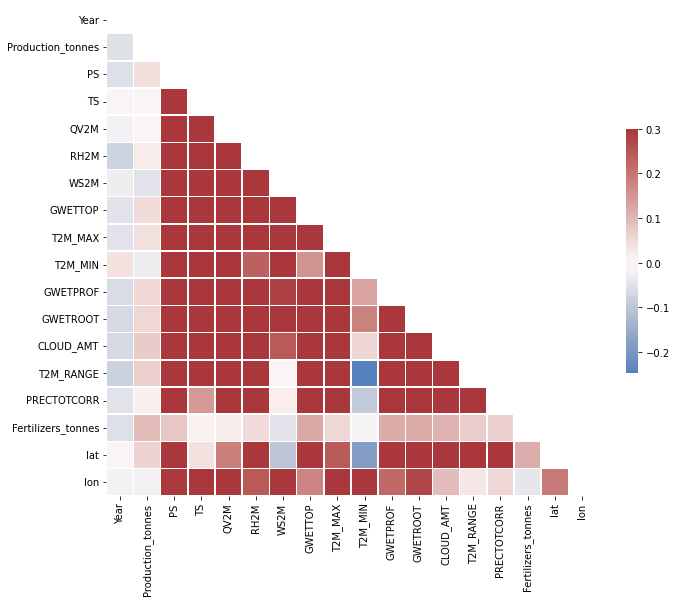

In [ ]:
correlation_data = yield_df.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
yield_df_onehot = pd.get_dummies(yield_df, columns=['City',"Type_crop"], prefix = ['Country',"Item"])	
features = yield_df_onehot.loc[:, yield_df_onehot.columns != 'Production_tonnes']
label = yield_df['Production_tonnes']
features.head()

,Year,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,...,Item_rye and winter cereal mixtures (maslin),Item_sorghum,Item_spring barley,Item_spring cereal mixtures (mixed grain other than maslin),Item_sugar beet,Item_sweet lupin,Item_sweet potatoes,Item_titicale,Item_winter barley,Item_winter cereal mixtures (maslin)
0,2006,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,...,0,0,0,0,0,0,0,0,0,0
1,2006,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,...,0,0,0,0,0,0,0,0,0,0
2,2006,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,...,0,0,0,0,0,0,0,0,0,0
3,2006,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,...,0,0,0,0,0,0,0,0,0,0
4,2006,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = features.drop(['Year'], axis=1)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208499 entries, 0 to 208498
Columns: 158 entries, PS to Item_winter cereal mixtures (maslin)
dtypes: float64(16), uint8(142)
memory usage: 53.7 MB


In [ ]:
features.head()

,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,...,Item_rye and winter cereal mixtures (maslin),Item_sorghum,Item_spring barley,Item_spring cereal mixtures (mixed grain other than maslin),Item_sugar beet,Item_sweet lupin,Item_sweet potatoes,Item_titicale,Item_winter barley,Item_winter cereal mixtures (maslin)
0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,...,0,0,0,0,0,0,0,0,0,0
1,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,...,0,0,0,0,0,0,0,0,0,0
2,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,...,0,0,0,0,0,0,0,0,0,0
3,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,...,0,0,0,0,0,0,0,0,0,0
4,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = scaler.fit_transform(features) 

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import r2_score

def compare_models(model):
    model_name = model.__class__.__name__
    model.fit(train_data, train_labels)
    y_pred = model.predict(test_data)
    r2 = r2_score(test_labels,y_pred)
    return [model_name, r2]

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    RandomForestRegressor(n_estimators=200, max_depth=8, random_state=0),
    AdaBoostRegressor(n_estimators=200, random_state=0),
    GradientBoostingRegressor(n_estimators=200, max_depth=8, random_state=0),
    svm.SVR(),
    DecisionTreeRegressor(),
    xgb.XGBRegressor(random_state=0, tree_method='gpu_hist', n_estimators=200, max_depth=8)
]

In [ ]:
model_train= list(map(compare_models,models)) 

In [ ]:
print(*model_train, sep = "\n")

In [ ]:
yield_df_onehot = yield_df_onehot.drop(['Year'], axis=1)
yield_df_onehot.head()

In [ ]:
#setting test data to columns from dataframe and excluding 'hg/ha_yield' values where ML model should be predicting 

test_df=pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'Production_tonnes'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=test_df[[col for col in test_df.columns if 'City' in col]].stack()[test_df[[col for col in test_df.columns if 'City' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]
itm=test_df[[col for col in test_df.columns if 'Type_crop' in col]].stack()[test_df[[col for col in test_df.columns if 'Type_crop' in col]].stack()>0]
itmlist=list(pd.DataFrame(itm).index.get_level_values(1))
items=[i.split("_")[1] for i in itmlist]

test_df.drop([col for col in test_df.columns if 'Type_crop' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'City' in col],axis=1,inplace=True)

test_df['City']=countries
test_df['Type_crop']=items
test_df.head()

In [ ]:
i = ...
clf= model_train[i][0]
model=clf.fit(train_data,train_labels)

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["Production_tonnes"].tolist()
test_group=test_df.groupby("Item")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

In [ ]:
# So let's run the model actual values against the predicted ones 

fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [ ]:
def adjusted_r_squared(y,yhat,x):
    score=1- (((1-(r2_score(y,yhat)))*(len(y)-1))/(len(y)-x.shape[1]-2))
    return score

test_group.apply(lambda x: adjusted_r_squared(x.yield_actual,x.yield_predicted,x))

In [ ]:
varimp= {'imp':model.feature_importances_,'names':yield_df_onehot.columns[yield_df_onehot.columns!="Production_tonnes"]}

In [ ]:
a4_dims = (8.27,16.7)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["imp"],inplace=True)
df=df.dropna()
sns.barplot(x="imp",y="names",palette="vlag",data=df,orient="h",ax=ax);